In [44]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display

%matplotlib inline

In [45]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()

ud = []
yd = []
done = False
T = 27
for i in range(T):
    action = env.action_space.sample()
    obs, rew, done, info, _ = env.step(action)
    ud.append(action)
    yd.append(obs)

env.close()

ud = np.array(ud)
yd = np.array(yd)

In [46]:
T_ini = 4
n = 4
N = 5

print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')

L = T_ini + N + n
H = hankel(ud[0:L], ud[L:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

yd shape : (27, 4)   ud shape : (27, 1)
H has rank 13 and shape (13, 14)


In [47]:
L = T_ini + N
y_row,y_col = yd.shape

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*y_col, T-L+1))
yd = yd.reshape((y_col*y_row,))
print(Y.shape)
for i in range(0,T-L+1):
    Y[:,i] = yd[y_col*i:y_col*(L+i)]

Up = U[0:T_ini, :]
Uf = U[T_ini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:y_col*T_ini, :]
Yf = Y[y_col*T_ini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = ud[:T_ini].reshape((T_ini,))
y_ini = yd[:y_col*T_ini].reshape((y_col*T_ini,))
print(f'u ini : {u_ini}\ny ini : {y_ini}')


(36, 19)
U = (9, 19), Up = (4, 19), Uf = (5, 19)
Y = (36, 19), Yp = (16, 19), Yf = (20, 19)
u ini : [-1.4278286 -0.5804618  1.4969238 -2.0840082]
y ini : [-0.01201783  0.01779371 -0.47942628  1.08718951 -0.03492741  0.06917878
 -0.66626822  1.48614089 -0.05156516  0.10540426 -0.16835399  0.34954001
 -0.07228065  0.15304676 -0.86487179  2.01492235]


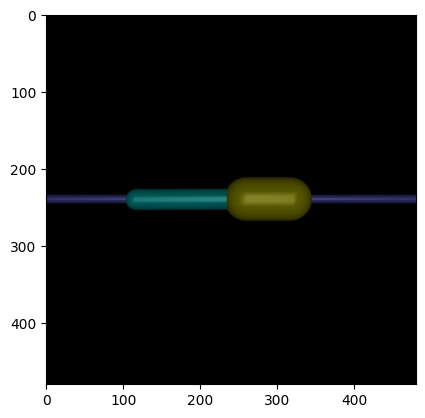

In [48]:
g = cp.Variable(T - T_ini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*y_col)
sig_y = cp.Variable(y_col*T_ini)

Q = np.eye(N*y_col)
R = np.eye(N)

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm1(g) + cp.norm1(sig_y)*0.1

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]

for i in range(30):

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini + sig_y,
    Uf @ g == u,
    Yf @ g == y
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.OSQP, verbose=False)

  # for i in range(T_ini):
  plt.imshow(env.render())
  display.display(plt.gcf())    
  display.clear_output(wait=True)
  action = prob.variables()[1].value[0]
  # print(action)
  obs,_,_,_,_ = env.step([action])
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
    
  # print(yT)
  u_ini = uT[-T_ini:]
  y_ini = yT[-y_col*T_ini:]





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(136,)


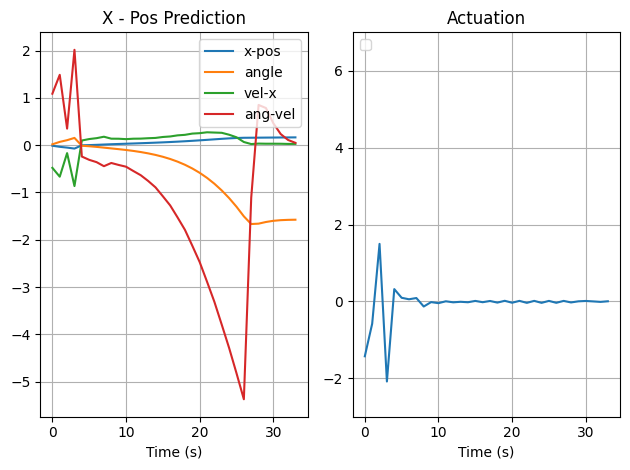

In [49]:
# time = np.array(list(range(0,N)))
# y = prob.variables()[0].value
# u = prob.variables()[1].value
yT = np.array(yT)
print(yT.shape)
yT = yT.reshape((34,4))
plt.subplot(1,2,1)
plt.plot(range(0,34), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("X - Pos Prediction")
# plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,34), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,7))
plt.grid('on')
plt.tight_layout()

plt.show()